### 3. Aplicación de algoritmos

Ahora nos embarcamos en la tarea de evaluar diversos modelos, buscando aquel que mejor se adapte a las complejidades de nuestro conjunto de datos. A lo largo de esta exploración, probaremos una gran variedad de modelos, desde aquellos más simples hasta los más complejos, con el objetivo de identificar el algoritmo que maximice la capacidad predictiva.

#### Importación librerías y funciones

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb 
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, fbeta_score,
    classification_report, confusion_matrix, roc_curve, auc,
    silhouette_score, make_scorer, precision_recall_curve, roc_auc_score
)

import time

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from funciones import evaluate_model

#### Carga de datos

In [4]:
pd_fraud = pd.read_csv('../data/seleccion.csv')

#### Split in Train, Validation and Test

Divimos el dataset en train y test, y posteriomente volvemos a dividir el train para obtener la validación, de esta manera tenemos train con un 60 % del dataset, y validación y test con un 20 % cada uno.

Train lo utilizaremos para entrenar el modelo y validación para predecir. Posteriomente, una vez hayamos escogido el modelo o modelos más óptimos, utilizaremos la primera partición de train para entrenar y test para predecir, ya con el modelo ajustado con los mejores hiperparámetros.

In [5]:
# Separate features (X) and the target variable (y) from the DataFrame
X = pd_fraud.drop('fraud_bool', axis=1)
y = pd_fraud['fraud_bool']

In [6]:
# Set a fixed random state value for reproducibility
random_state_value = 123

In [7]:
# Split the data into training (training_0) and test sets
X_train_0, X_test, y_train_0, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state_value)

# Split the training (training_0) set into training (training_1) and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_0, y_train_0, test_size=0.25, random_state=random_state_value)

# Create DataFrames for the training, validation, and test sets
pd_fraud_train = pd.concat([y_train, X_train], axis=1)
pd_fraud_val = pd.concat([y_val, X_val], axis=1)
pd_fraud_test = pd.concat([y_test, X_test], axis=1)

# Create a DataFrame for the original training set (training_0) that will be used in the following notebook
pd_fraud_train_0 = pd.concat([y_train_0, X_train_0], axis=1)

Comprobamos que tanto train como validacion como test siguen una distribución muy similar en cuanto al fraude

In [8]:
# Print normalized value counts for the 'fraud_bool' column in the training set
print('== Train ==\n', pd_fraud_train['fraud_bool'].value_counts(normalize=True))

# Print normalized value counts for the 'fraud_bool' column in the validation set
print('== Val ==\n', pd_fraud_val['fraud_bool'].value_counts(normalize=True))

# Print normalized value counts for the 'fraud_bool' column in the test set
print('== Test ==\n', pd_fraud_test['fraud_bool'].value_counts(normalize=True))


== Train ==
 fraud_bool
0    0.988927
1    0.011073
Name: proportion, dtype: float64
== Val ==
 fraud_bool
0    0.98905
1    0.01095
Name: proportion, dtype: float64
== Test ==
 fraud_bool
0    0.989025
1    0.010975
Name: proportion, dtype: float64


#### Oversampling

Dado el gran desbalanceo que presenta el dataset decidimos realizar oversampling con el objetivo de dotar a los modelos de una muestra balanceada que consiga mejorar nuestras predicciones.

En nuestro al enfretarnos a un dataset tan altamente desbalanceado, la decisión de realizar un oversampling colocando la clase minoritaria en torno al 33% obedece al objetivo de mitigar el desequilibrio de clases y preservar la integridad de la distribución de los datos.

En la detección de fraudes, por ejemplo, donde las transacciones fraudulentas son eventos poco frecuentes, el gran desequilibrio inicial de clases plantea retos para el entrenamiento del modelo. Limitarse a buscar un equilibrio del 50-50 podría llevar a una extrema sobrerrepresentación de muestras sintéticas para la clase minoritaria, lo que podría introducir ruido e imprecisiones.

Al seleccionar un objetivo más moderado, en torno al 33%, reconocemos la rareza de la clase minoritaria y buscamos un equilibrio que mejore la capacidad del modelo para aprender patrones significativos sin eclipsar la distribución original de los datos. Este enfoque pretende mejorar la sensibilidad del modelo a la clase minoritaria, evitando al mismo tiempo un énfasis exagerado que pueda comprometer su rendimiento en escenarios desequilibrados del mundo real.

In [9]:
# Define the desired ratio of the minority to majority class after SMOTE
desired_ratio = 0.5

# Initialize the SMOTE (Synthetic Minority Over-sampling Technique) with the specified sampling strategy and random state
smote = SMOTE(sampling_strategy=desired_ratio, random_state=random_state_value)

# Apply SMOTE to the training set to balance the class distribution
X_train, y_train = smote.fit_resample(X_train, y_train)



In [10]:
# Count the occurrences of each class in the target variable (y_train)
fraud_count = pd.value_counts(y_train)

# Calculate the percentage of each class
fraud_percentage = fraud_count / len(y_train) * 100

# Create a DataFrame with the count and percentage of each class
result_df = pd.DataFrame({'Count': fraud_count, 'Percentage': fraud_percentage})

# Print the resulting DataFrame
print(result_df)

             Count  Percentage
fraud_bool                    
0           593356   66.666667
1           296678   33.333333


### Modelo Base

En primer lugar, efectuaremos el modelo base mediante la imputación de las predicciones a la clase mayoritaria, en este caso a la clase 0 (solicitud no fraudulenta) obviamente.

Dado el gran desbalanceo del dataset lograremos un Accuracy superior al 98%. Este modelo nos servira como marco de referencia previo al entrenamiento del resto de modelos.

In [11]:
# Create a baseline prediction array with zeros for the length of the validation set target variable (y_val)
base_pred = [0] * len(y_val)

# Convert the list to a NumPy array
base_pred = np.array(base_pred)

In [12]:
# Calculate accuracy by comparing the actual target values (y_val) with the baseline predictions (base_pred)
accuracy = accuracy_score(y_val, base_pred)

# Print the accuracy value
accuracy

0.98905

Obviamente el modelo base tiene un accuracy extremadamente alto, ya que el problema ante el que nos encontramos esta extremadamente desbalanceado, de esta manera al predecir todos los resultados como la clase mayoritaria, clase 0, el modelo base detecta todos los no fraudes pero los fraudes que son como hemos visto aproximadamente el 1 % del total no se detectan, debido a ello, nos encontramos con las siguientes matrices de confusión.

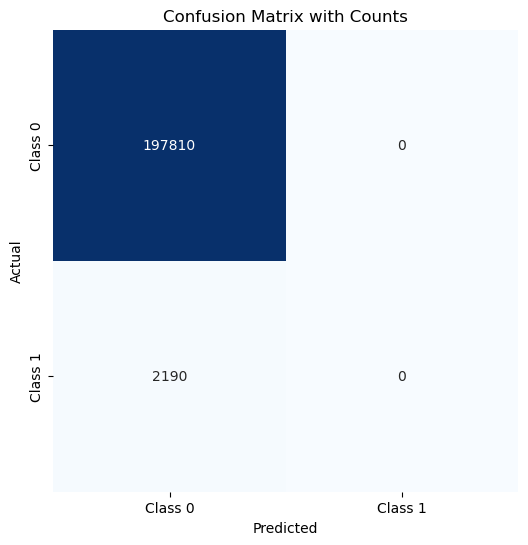

In [13]:
# Calculate the confusion matrix with counts using the actual target values (y_val) and baseline predictions (base_pred)
conf_matrix_counts = confusion_matrix(y_val, base_pred)

# Plot a heatmap of the confusion matrix with annotations
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_counts, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix with Counts')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

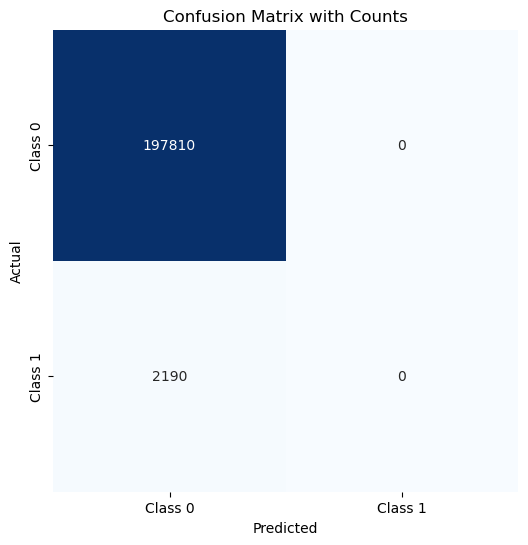

In [14]:
# Calculate the confusion matrix with counts using the actual target values (y_val) and baseline predictions (base_pred)
conf_matrix_counts = confusion_matrix(y_val, base_pred)

# Plot a heatmap of the confusion matrix with annotations
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_counts, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix with Counts')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Modelos

En primer lugar entrenaremos una variedad de modelos y extraeremos varias métricas, estos modelos serán entrenados con los hiperparámetros por defecto, no se llevará a cabo ningún ajuste.

- Decision Tree: Un modelo que toma decisiones recursivas basadas en características para clasificar datos. Divide el conjunto de datos en ramas según reglas lógicas.


- Naive Bayes: Un clasificador probabilístico basado en el teorema de Bayes. Asume independencia condicional entre las características dadas las clases y es efectivo para datos con alta dimensionalidad.

- GLM (Generalized Linear Model): Un enfoque estadístico que generaliza la regresión lineal, permitiendo diferentes distribuciones y funciones de enlace. En el contexto de la clasificación, se utiliza para modelar la relación entre variables predictoras y la probabilidad de pertenecer a una clase.

- SVM (Support Vector Machine): Un algoritmo que encuentra un hiperplano de separación óptimo entre clases en un espacio de características de alta dimensión. Es efectivo para conjuntos de datos no lineales mediante el uso de funciones de kernel.

- Random Forest: Random Forest es un modelo basado en la técnica de ensamblado llamada Bagging (Bootstrap Aggregating). En un Random Forest, se construye un conjunto de árboles de decisión durante el entrenamiento, donde cada árbol es entrenado en una muestra aleatoria del conjunto de datos original. Este proceso de muestreo aleatorio se conoce como bootstrap sampling. La palabra "random" en Random Forest se refiere a la introducción adicional de aleatoriedad durante la construcción de cada árbol.

- XGBoost: Una implementación eficiente y escalable de algoritmos de gradient boosting, diseñada para mejorar la velocidad y rendimiento. Utiliza árboles de decisión como modelos base y se enfoca en la optimización de la función de pérdida.

- LightGBM: Otra biblioteca de gradient boosting que se destaca por su eficiencia y velocidad. Utiliza el algoritmo de Gradient Boosting, pero utiliza estrategias de crecimiento de árboles diferentes para mejorar la eficiencia computacional.

XGBoost y LightGBM son algoritmos de gradient boosting para el aprendizaje supervisado, pero difieren en aspectos clave. XGBoost emplea una estrategia de crecimiento de árbol en profundidad, mientras que LightGBM utiliza una estrategia de crecimiento en hojas, lo que reduce el tiempo de entrenamiento. En cuanto a las características categóricas, XGBoost requiere preprocesamiento, mientras que LightGBM las admite de forma nativa. En cuanto a la paralelización, XGBoost funciona con bloques de columnas, mientras que LightGBM utiliza bloques de filas. LightGBM está diseñado para ahorrar más memoria, lo que lo hace adecuado para grandes conjuntos de datos. XGBoost está ampliamente extendido y probado, y funciona bien en conjuntos de datos pequeños y medianos, mientras que LightGBM está optimizado para la velocidad, especialmente en conjuntos de datos grandes. El ajuste de los parámetros es similar, pero las diferencias en el crecimiento del árbol y el tratamiento de las características categóricas pueden afectar a sus interpretaciones. La elección depende de las características del conjunto de datos, los recursos disponibles y el equilibrio deseado entre velocidad y rendimiento.


- Adaboost: Un algoritmo de boosting que combina varios clasificadores débiles para formar un clasificador fuerte. Se centra en mejorar la precisión corrigiendo los errores de los clasificadores anteriores.

- Gradient Boost: Un enfoque de boosting que construye una serie de modelos de manera secuencial, cada uno corrigiendo los errores del modelo anterior. Es eficaz para mejorar la precisión y puede adaptarse a diversos conjuntos de datos.


AdaBoost y Gradient Boosting son ambos métodos de ensamblado que buscan mejorar el rendimiento de modelos más simples al combinar múltiples clasificadores débiles. Sin embargo, difieren en su enfoque para corregir los errores y asignar importancia a las instancias del conjunto de datos.
En AdaBoost, cada clasificador débil se entrena secuencialmente, y se da más peso a las instancias mal clasificadas en cada iteración. Esto permite que los clasificadores se centren en corregir los errores cometidos por los clasificadores anteriores, ajustando los pesos de las instancias de manera adaptativa.
En Gradient Boosting, el enfoque se basa en ajustar modelos adicionales para corregir los residuos (diferencias entre las predicciones actuales y las reales) de los modelos anteriores. Cada nuevo clasificador se enfoca en reducir los errores restantes en el conjunto de datos

In [15]:
# Create a dictionary of machine learning models, each initialized with its respective classifier
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB(),
    'GLM': LogisticRegression(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'XGBOOST': xgb.XGBClassifier(),
    'LightGBM': lgb.LGBMClassifier(),
    'Adaboost': AdaBoostClassifier(),
    'Gradient Boost': GradientBoostingClassifier()
}


El modelo SVM (Support Vector Machine) es un modelo muy exigente computacionalmente, debido a ello lo ejecutaremos solo en una parte del train, de esta manera comprobaremos que dado du elevado tiempo de ejecución en un parte muy pequeña del dataset no es factible trabajar con él.

In [16]:
# Evaluate each machine learning model and print the results

for model_name, model in models.items():
    print(f"=== {model_name} ===")
    
    # For SVM, fit on a smaller subset for demonstration due to longer execution time
    if model_name == 'SVM':
        accuracy, precision, recall, f1, f2, execution_time = evaluate_model(model, X_train.head(10000), y_train.head(10000), X_val, y_val)
    else:
        accuracy, precision, recall, f1, f2, execution_time = evaluate_model(model, X_train, y_train, X_val, y_val)
    
    # Print evaluation metrics for each model
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"F2 Score: {f2:.4f}")
    print(f"Execution Time: {execution_time:.2f} seconds")
    print("=" * 30)


    

=== Decision Tree ===
Accuracy: 0.9725
Precision: 0.0710
Recall: 0.1251
F1 Score: 0.0906
F2 Score: 0.1086
Execution Time: 53.00 seconds
=== Naive Bayes ===
Accuracy: 0.2651
Precision: 0.0140
Recall: 0.9539
F1 Score: 0.0276
F2 Score: 0.0662
Execution Time: 1.56 seconds
=== GLM ===
Accuracy: 0.8933
Precision: 0.0656
Recall: 0.6603
F1 Score: 0.1194
F2 Score: 0.2348
Execution Time: 4.60 seconds
=== SVM ===
Accuracy: 0.9890
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
F2 Score: 0.0000
Execution Time: 27.05 seconds
=== Random Forest ===
Accuracy: 0.9880
Precision: 0.2725
Recall: 0.0553
F1 Score: 0.0919
F2 Score: 0.0657
Execution Time: 536.17 seconds
=== XGBOOST ===
Accuracy: 0.9887
Precision: 0.3937
Recall: 0.0516
F1 Score: 0.0912
F2 Score: 0.0625
Execution Time: 5.86 seconds
=== LightGBM ===
[LightGBM] [Info] Number of positive: 296678, number of negative: 593356
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083375 seconds.
You can set `force_r

A la hora de entrenar los diferentes modelos hemos obtenido 6 métricas por modelo: Accuracy, Precision, Recall, F1, F2 y el tiempo de ejecución. A la hora de seleccionar el mejor o mejores modelos, nos guiaremos principalmente del F2 score.

El F2 nos será de gran utilidad, ya que se trata de una métrica más óptima cuando tratamos de reducir los Falsos Negativos. En nuestro problema, queremos reducir los fraudes que en la predicción se clasifican como no fraudes, y estaremos dispuestos a asumir más Falsos Positivos, esto es no fraudes que se clasifican como fraudes en la predicción.

Al priorizar el recall, el modelo se vuelve más efectivo en identificar un mayor porcentaje de solicitudes fraudulentas, reduciendo así la probabilidad de que eventos de fraude pasen desapercibidos. En el contexto bancario, donde la detección temprana y precisa de actividades fraudulentas es esencial para proteger los activos y la integridad del sistema financiero, la métrica F2 se alinea de manera óptima con el objetivo de minimizar los falsos negativos.

Debido a ello consideramos F2 como la métrica más óptima, pues otorga más importancia al Recall que a Precision, y nos proporciona un equilibrio adecuado para asegurarnos de que el modelo sigue siendo adecuado en términos de precisión.







A la hora de escoger el modelo ganador vemos que existen 3 modelos con un F2 superior a 0.2, que son GLM, Adaboost y Gradient Boost. El GLM es peor que el Adaboost en todas las métricas a excepción del recall y el tiempo de ejecución. El Gradient Boost mejora al Adaboost es accuracy, precision y F1, sin embargo es mucho más lento que el Adaboost.

Por lo comentado anteriormente, decidimos escoger como modelo ganador el algoritmo Adaboost, ya que es el que consigue mayor F2 y consigue buenos valores para el resto de métricas.

In [17]:
# Save the training set (pd_fraud_train_0) to a CSV file named 'train.csv' in the 'data' directory without including the index
pd_fraud_train_0.to_csv('../data/train.csv', index=False)

# Save the test set (pd_fraud_test) to a CSV file named 'test.csv' in the 'data' directory without including the index
pd_fraud_test.to_csv('../data/test.csv', index=False)